In [5]:
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q
import numpy as np
import pygsti
%matplotlib inline
import matplotlib.pyplot as plt
import scipy
from pygsti.modelpacks import smq2Q_XYICPHASE

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [6]:
exp_line_labels = (0,1)#What are the labels for the qubits we'll be doing RPE on?

In [7]:
state_pair_lookup = {(0,2):{('cos','+'):'01', ('cos','-'):'00',
                            ('sin','+'):'00', ('sin','-'):'01'},
                     (1,2):{('cos','+'):'00', ('cos','-'):'10',
                            ('sin','+'):'00', ('sin','-'):'10'},
                     (1,3):{('cos','+'):'11', ('cos','-'):'10',
                            ('sin','+'):'00', ('sin','-'):'01'}}

In [8]:
pygsti.circuits.Circuit([[('Gypi2',1)]],line_labels=(0,1))*3+pygsti.circuits.Circuit([[('Gypi2',0)]],line_labels=(0,1))

NameError: name 'pygsti' is not defined

In [9]:
def make_cos_circ(k,state_pair,line_labels=(0,1)):
    if state_pair in [(0,2), (2,0)]:  #<01| for (1+cos(1/2 (theta_ix + theta_zx))
                                      #<00| for (1-cos(1/2 (theta_ix + theta_zx))
        circ = (pygsti.circuits.Circuit([[('Gxpi2',line_labels[1])],
                                          ('Gxpi2',line_labels[1])],
                                        line_labels=line_labels)+
                pygsti.circuits.Circuit([[('Gcr',line_labels[0],line_labels[1])]])*k)
    elif state_pair in [(1,2), (2,1)]:#<00| for (1+cos(1/2 (theta_zi - theta_zx))
                                      #<10| for (1+cos(1/2 (theta_zi - theta_zx))
        circ = (pygsti.circuits.Circuit([[('Gypi2',line_labels[0])]],line_labels=line_labels)+
                pygsti.circuits.Circuit([[('Gypi2',line_labels[1])]],line_labels=line_labels)*3+
                pygsti.circuits.Circuit([[('Gcr',line_labels[0],line_labels[1])]])*k+
                pygsti.circuits.Circuit([[('Gypi2',line_labels[0])]],line_labels=line_labels)*3+
                pygsti.circuits.Circuit([[('Gypi2',line_labels[1])]],line_labels=line_labels))
    elif state_pair in [(1,3), (3,1)]:#<11| for (1+cos(1/2 (theta_ix - theta_zx))
                                      #<10| for (1-cos(1/2 (theta_ix - theta_zx))
        circ = (pygsti.circuits.Circuit([[('Gxpi2',line_labels[0])]],line_labels=line_labels)*2+
                pygsti.circuits.Circuit([[('Gxpi2',line_labels[1])]],line_labels=line_labels)*2+
                pygsti.circuits.Circuit([[('Gcr',line_labels[0],line_labels[1])]])*k)
    else:
        assert False, "state_pair must be in [(0,2), (2,0), (1,2), (2,1), (1,3), (3,1)]"
    return circ

    
def make_sin_circ(k,state_pair,line_labels=(0,1)):
    if state_pair in [(0,2), (2,0)]:  #<00| for (1+sin(1/2 (theta_ix + theta_zx))
                                      #<01| for (1+sin(1/2 (theta_ix - theta_zx))
        circ = (pygsti.circuits.Circuit([[('Gxpi2',line_labels[1])],
                                          ('Gxpi2',line_labels[1])],
                                        line_labels=line_labels)+
                pygsti.circuits.Circuit([[('Gcr',line_labels[0],line_labels[1])]])*k+
                pygsti.circuits.Circuit([[('Gxpi2',line_labels[1])]]))
    elif state_pair in [(1,2),(2,1)]:#<00| for (1+sin(1/2 (theta_zi - theta_zx))
                                     #<10| for (1+sin(1/2 (theta_zi - theta_zx))
        circ = (pygsti.circuits.Circuit([[('Gypi2',line_labels[0])]],line_labels=line_labels)+
                pygsti.circuits.Circuit([[('Gypi2',line_labels[1])]],line_labels=line_labels)*3+
                pygsti.circuits.Circuit([[('Gcr',line_labels[0],line_labels[1])]])*k+
                pygsti.circuits.Circuit([[('Gxpi2',line_labels[0])],
                                         [('Gypi2',line_labels[1])]]))
    elif state_pair in [(1,3), (3,1)]:#<0-| for (1+sin(1/2 (theta_ix - theta_zx))
                                      #<01| for (1-sin(1/2 (theta_ix - theta_zx))
        circ = (pygsti.circuits.Circuit([[('Gxpi2',line_labels[0])]],line_labels=line_labels)*2+
                pygsti.circuits.Circuit([[('Gxpi2',line_labels[1])]],line_labels=line_labels)*2+
                pygsti.circuits.Circuit([[('Gcr',line_labels[0],line_labels[1])]])*k+
                pygsti.circuits.Circuit([[('Gxpi2',line_labels[0])]])*2+
                pygsti.circuits.Circuit([[('Gxpi2',line_labels[1])]]))
    else:
        assert False, "state_pair must be in [(0,2), (2,0), (1,2), (2,1), (1,3), (3,1)]"
    return circ


In [10]:
#Make the unitary cross-resonance gate.  Target angle is (0,0,pi/2).
def CR(theta_ix,theta_zi,theta_zx):
    return scipy.linalg.expm(-1j/2 * (theta_ix * pygsti.sigmaix + theta_zi * pygsti.sigmazi + theta_zx * pygsti.sigmazx))

In [11]:
def rectify_angle(theta):
    if theta > np.pi:
        theta -= 2*np.pi
    return theta

In [12]:
max_depths = [1,2,4,8,16,32]
#Can go shallower or deeper; chose 32 somewhat arbitrarily for this demo.  
#The deeper we can go, the better (up to depolarization).

In [13]:
state_pairs = [(0,2), (1,2), (1,3)]

In [14]:
sin_dict = {state_pair: {i: make_sin_circ(i,state_pair,exp_line_labels) for i in max_depths} for state_pair in state_pairs}
cos_dict = {state_pair: {i: make_cos_circ(i,state_pair,exp_line_labels) for i in max_depths} for state_pair in state_pairs}

circ_dict = {'sin':sin_dict,'cos':cos_dict}

all_circs = []
for trig_dict in [sin_dict,cos_dict]:
    for state_pair in state_pairs:
        all_circs += list(trig_dict[state_pair].values())

all_circs = pygsti.remove_duplicates(all_circs)

NameError: name 'pygsti' is not defined

In [15]:
target_model = smq2Q_XYICPHASE.target_model(qubit_labels=exp_line_labels)

NameError: name 'smq2Q_XYICPHASE' is not defined

In [16]:
target_model['Gcr',0,1] = pygsti.unitary_to_pauligate(CR(0,0,np.pi/2))

NameError: name 'pygsti' is not defined

In [17]:
target_theta_ix = 0
target_theta_zi = 0
target_theta_zx = np.pi/2

In [14]:
#Define the rotation angles used for the simulated dataset.
#Injecting noise via the delta_theta terms as a sanity check.
#To emulate perfect behavior, set these three terms to 0.
delta_theta_ix =  0.1
delta_theta_zi = -0.2
delta_theta_zx =  0.3

theta_ix = target_theta_ix + delta_theta_ix
theta_zi = target_theta_zi + delta_theta_zi
theta_zx = target_theta_zx + delta_theta_zx

noisy_model = target_model.copy()
noisy_model['Gcr',exp_line_labels[0],exp_line_labels[1]] = pygsti.unitary_to_pauligate(
    CR( theta_ix,
        theta_zi,
        theta_zx))

In [15]:
#What are the linear combinations of phases we'll be reconstructing?
print(f'(0,2):(theta_ix+theta_zx)={(theta_ix+theta_zx)}')#(0,2)
print(f'(1,2):(theta_zi-theta_zx)={(theta_zi-theta_zx)}')#(1,2)
print(f'(1,3):(theta_ix-theta_zx)={(theta_ix-theta_zx)}')#(1,3)

(0,2):(theta_ix+theta_zx)=1.9707963267948967
(1,2):(theta_zi-theta_zx)=-2.0707963267948966
(1,3):(theta_ix-theta_zx)=-1.7707963267948965


In [16]:
#Make an RPE dataset with the noisy model
N = 100#Number of repetitions per circuit
dataset_0 = pygsti.data.simulate_data(noisy_model,all_circs,N)

/Users/kmrudin/pyGSTi-0.9.10-develop/pygsti/layouts/evaltree.py:183: UserWarning: Created an evaluation tree that is inefficient: tree-size > 3 * #circuits !
This is likely due to the fact that the circuits being simulated do not have a
periodic structure. Consider using a different forward simulator (e.g. MapForwardSimulator).
  _warnings.warn(("Created an evaluation tree that is inefficient: tree-size > %d * #circuits !\n"


In [17]:
pygsti.io.write_dataset('dataset_cr_three_phase_demo-1.txt',dataset_0)

In [18]:
dataset_1 = pygsti.io.read_dataset('dataset_cr_three_phase_demo-1.txt')

Reading dataset_cr_three_phase_demo-1.txt: 100%


In [19]:
#Post-process the RPE data from the pyGSTi dataset
the_experiments = {}
for state_pair in state_pairs:
    the_experiments[state_pair] = Q()

for state_pair in state_pairs:
    cos_plus = state_pair_lookup[state_pair]['cos','+']
    cos_minus = state_pair_lookup[state_pair]['cos','-']
    sin_plus = state_pair_lookup[state_pair]['sin','+']
    sin_minus = state_pair_lookup[state_pair]['sin','-']
    for i in max_depths:
        the_experiments[state_pair].process_sin(i,(int(dataset_0[sin_dict[state_pair][i]][sin_plus]),
                                                   int(dataset_0[sin_dict[state_pair][i]][sin_minus])))
        the_experiments[state_pair].process_cos(i,(int(dataset_0[cos_dict[state_pair][i]][cos_plus]),
                                                   int(dataset_0[cos_dict[state_pair][i]][cos_minus])))

In [20]:
analyses = {}

In [21]:
for state_pair in state_pairs:
    analyses[state_pair] = RobustPhaseEstimation(the_experiments[state_pair])
#    if state_pair in [(1,2),(1,3)]:
#        analyses[state_pair].angle_estimates = [rectify_angle(theta) for theta in analyses[state_pair].angle_estimates]#rectify_angle(analyses[state_pair].angle_estimates)
#

In [22]:
#Extract the last "trusted" RPE angle estimate.  This is the quantity that will get fed to the optimizer.
#Have to do this step (for now) prior to shifting angle into correct principle range.

last_good_estimate_generations = {}

for state_pair in state_pairs:
    last_good_estimate_generations[state_pair] = analyses[(state_pair)].check_unif_local(historical=True)

last_good_estimate_generation = min(list(last_good_estimate_generations.values()))

print(f'Last good generation is generation {last_good_estimate_generation} (depth L={2**last_good_estimate_generation})')


Last good generation is generation 5 (depth L=32)


In [23]:
#Now shift angles into correct principle range.
for state_pair in state_pairs:
    if state_pair in [(1,2),(1,3)]:#If you're getting funny results for your (0,2) pair estimate, try including (0,2) here as well.
        analyses[state_pair].angle_estimates = [rectify_angle(theta) for theta in analyses[state_pair].angle_estimates]#rectify_angle(analyses[state_pair].angle_estimates)


In [24]:
#Reminder of the targets for the linear combinations of the phases we'll be reconstructing.
#(Can't know these without actually knowing true phases.)
print(f'(0,2):(theta_ix+theta_zx)={(theta_ix+theta_zx)}')#(0,2)
print(f'(1,2):(theta_zi-theta_zx)={(theta_zi-theta_zx)}')#(1,2)
print(f'(1,3):(theta_ix-theta_zx)={(theta_ix-theta_zx)}')#(1,3)

(0,2):(theta_ix+theta_zx)=1.9707963267948967
(1,2):(theta_zi-theta_zx)=-2.0707963267948966
(1,3):(theta_ix-theta_zx)=-1.7707963267948965


In [25]:
#What linear comibnations of phases did we reconstruct?
for state_pair in state_pairs:
    print(state_pair)
    print(analyses[state_pair].angle_estimates)
    print()

(0, 2)
[1.91382027 1.98586852 1.93363818 1.97098643 1.97341136 1.97210247]

(1, 2)
[-2.0061496019471985, -2.0516127573619585, -2.0633742819934646, -2.0767481374908145, -2.0705387448310617, -2.072881762364257]

(1, 3)
[-1.843805029881607, -1.7252616987567677, -1.793365102326817, -1.7746368870344096, -1.7708913773393347, -1.7745066482917862]



In [26]:
#Turn lin. comb. estimates into direct phase estimates.
theta_ix_estimates = 0.5 * (np.array(analyses[(0,2)].angle_estimates) + np.array(analyses[(1,3)].angle_estimates))
theta_zx_estimates = 0.5 * (np.array(analyses[(0,2)].angle_estimates) - np.array(analyses[(1,3)].angle_estimates))
theta_zi_estimates = np.array(analyses[(1,2)].angle_estimates)+theta_zx_estimates

(0.0005, 0.09979942262683393)

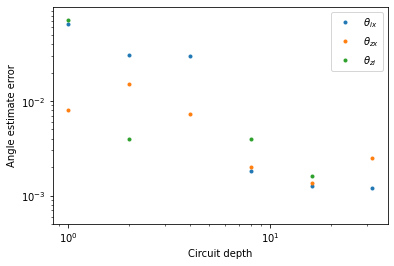

In [27]:
#Can plot accuracy of estimates when truth is known.  (Can't do this for experimental data.)
plt.plot(max_depths,np.abs(theta_ix - theta_ix_estimates),'.',label=r'$\theta_{ix}$')
plt.plot(max_depths,np.abs(theta_zx - theta_zx_estimates),'.',label=r'$\theta_{zx}$')
plt.plot(max_depths,np.abs(theta_zi - theta_zi_estimates),'.',label=r'$\theta_{zi}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Circuit depth')
plt.ylabel('Angle estimate error')
plt.legend()
plt.ylim(bottom=5e-4)

In [28]:
print(analyses[(0,2)].angle_estimates)
print(analyses[(1,2)].angle_estimates)
print(analyses[(1,3)].angle_estimates)

[1.91382027 1.98586852 1.93363818 1.97098643 1.97341136 1.97210247]
[-2.0061496019471985, -2.0516127573619585, -2.0633742819934646, -2.0767481374908145, -2.0705387448310617, -2.072881762364257]
[-1.843805029881607, -1.7252616987567677, -1.793365102326817, -1.7746368870344096, -1.7708913773393347, -1.7745066482917862]


In [29]:
#What are the actual phase estimates (in radians) for all depths?
print(f'theta_ix : {theta_ix_estimates}')
print(f'theta_zx : {theta_zx_estimates}')
print(f'theta_zi : {theta_zi_estimates}')

theta_ix : [0.03500762 0.13030341 0.07013654 0.09817477 0.10125999 0.09879791]
theta_zx : [1.87881265 1.85556511 1.86350164 1.87281166 1.87215137 1.87330456]
theta_zi : [-0.12733695 -0.19604765 -0.19987264 -0.20393648 -0.19838737 -0.1995772 ]


In [30]:
#Get final trusted estimates:
#What are the actual phase estimates (in radians) for all depths?
print(f'Trusted theta_ix : {theta_ix_estimates[last_good_estimate_generation]}')
print(f'Trusted theta_zx : {theta_zx_estimates[last_good_estimate_generation]}')
print(f'Trusted theta_zi : {theta_zi_estimates[last_good_estimate_generation]}')

Trusted theta_ix : 0.0987979129711678
Trusted theta_zx : 1.873304561262954
Trusted theta_zi : -0.19957720110130284
